In [1]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

KeyboardInterrupt: 

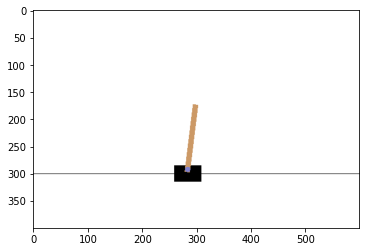

In [4]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v0").unwrapped

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001
n_iters=100

actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)
optimizerA = optim.Adam(actor.parameters())
optimizerC = optim.Adam(critic.parameters())
for iter in range(n_iters):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    
    for i in count():
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)

        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state

        if done:
            print('Iteration: {}, Score: {}'.format(iter, i))
            break


    next_state = torch.FloatTensor(next_state).to(device)
    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizerA.step()
    optimizerC.step()
torch.save(actor, 'model/actor.pkl')
torch.save(critic, 'model/critic.pkl')
env.close()